In [38]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [39]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [40]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "BHL10"

In [41]:
from typing import List, Literal, Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, AnyMessage
from langgraph.graph.message import add_messages
import operator

In [42]:
class MainAction(TypedDict):
    next_action: Literal["spacecraft_action","time_action","cost_action","asteroids_action"] = Field(description="Next action to execute in mission planning phase")
    messages: str

class Asteroid(BaseModel):
    Name: str
    OCC:str
    Diameter: str
    TOF: str
    Launch_date: str
    Min_dv: str
    Duration: str
    Stay: str
    Class: str
    @property
    def asteroid(self) -> str:
        return f"Name: {self.name}\nOCC: {self.OCC}\nDiameter: {self.Diameter}\nTOF: {self.TOF}\nLaunch_date: {self.Launch_date}\nMin_dv: {self.Min_dv}\nDuration: {self.Duration}\nStay: {self.Stay}\nClass: {self.Class}\n"
    
class Asteroids(BaseModel):
    Asteroids: List[Asteroid] = Field(
        description="Comprehensive list of asteroids for mission.",
    )
class MissionState(TypedDict):
    next_action: Literal["spacecraft_action","time_action","cost_action","asteroids_action","summary_action"] = Field(description="Next action to execute in mission planning phase")
    asteroids: Annotated[list, operator.add] = Field(description = "Potential destinations for mission")
    spacecraft: Annotated[list, operator.add] = Field(description = "List of potential spacecrafts for mission")
    time: Annotated[list, operator.add] = Field(description="List of insights for time perspectives of mission based on asteroids and spacecrafts data")
    cost: Annotated[list, operator.add] = Field(description="List of insights for costs and profits of mission based on asteroids and spacecrafts data")
    budget_analysis: str = Field(description="Analysis of budget")
    timeline_analysis: str = Field(description="Analysis of timeline")
    messages: Annotated[list, operator.add]
    table: str
    # analysts: List[Analyst]
    # messages: Annotated[list[AnyMessage], add_messages]
    # messages: list[AnyMessage]

class MissionState2(TypedDict):
    next_action: Literal["spacecraft_action","time_action","cost_action","asteroids_action","summary_action"] = Field(description="Next action to execute in mission planning phase")
    # asteroids: list = Field(description = "Potential destinations for mission")
    # spacecraft: list = Field(description = "List of potential spacecrafts for mission")
    # time: list = Field(description="Time windows to start mission")
    # cost: list = Field(description="Cost of mission based on asteroids and spacecrafts")
    messages: str = Field(description="Your question to experts about specific informations")

class CostState(TypedDict):
    # next_action: Literal["spacecraft_action","time_action","cost_action","asteroids_action","summary_action"] = Field(description="Next action to execute in mission planning phase")
    # asteroids: list = Field(description = "Potential destinations for mission")
    # spacecraft: list = Field(description = "List of potential spacecrafts for mission")
    # time: list = Field(description="Time windows to start mission")
    cost: list = Field(description="List of insights for costs and profits of mission based on asteroids and spacecrafts data")
    budget_analysis: str
    # messages: str = Field(description="Your question to experts about specific informations")

class TimeState(TypedDict):
    # next_action: Literal["spacecraft_action","time_action","cost_action","asteroids_action","summary_action"] = Field(description="Next action to execute in mission planning phase")
    # asteroids: list = Field(description = "Potential destinations for mission")
    # spacecraft: list = Field(description = "List of potential spacecrafts for mission")
    time: list = Field(description="List of insights for time perspectives of mission based on asteroids and spacecrafts data")
    timeline_analysis: str
    # cost: list = Field(description="List of insights for costs and profits of mission based on asteroids and spacecrafts data")
    # messages: str = Field(description="Your question to experts about specific informations")

class text2sqlState(TypedDict):
    next_action: Literal["mission_planner","text2sql"] = Field(description="Next action to execute in mission planning phase")
    asteroids: list = Field(description = "Potential destinations for mission")
    spacecraft: list = Field(description = "List of potential spacecrafts for mission")
    time: list = Field(description="Time windows to start mission")
    messages: str
    table: str
# class ResearchGraphState(TypedDict):
#     topic: str # Research topic
#     max_analysts: int # Number of analysts
#     human_analyst_feedback: str # Human feedback
#     analysts: List[Analyst] # Analyst asking questions
#     sections: Annotated[list, operator.add] # Send() API key
#     introduction: str # Introduction for the final report
#     content: str # Content for the final report
#     conclusion: str # Conclusion for the final report
#     final_report: str # Final report

# class MissionState(MessagesState):
#     next_action: Literal["file_summary","final_raport"] = Field(description="Next action to execute")
#     file: str = Field(description="If next action is 'file_summary' name of a file to summary")

In [43]:
import re
import sqlite3

text2sql_prompt_asteroid = """You are expert in writing sql queries for retrieving most well fited dataset to user query.

Use {table}. Limit answers to 5 rows.

{table} schema:

Spkid INTEGER NOT NULL -- Small-Body Perturbation Kernel Identifier.
Surname TEXT NOT NULL -- Catalogue Name of Asteroid.
Name TEXT -- Common Name of Asteroid (not everyone has it).
OCC INTEGER NOT NULL -- Orbit condition code, defines the asteroid’s orbit accuracy where 0 implies a well-determined orbit and 9 implies a very poorly-determined (highly uncertain) orbit.
Diameter REAL NOT NULL -- Mean Diameter in kilometers.
TOF REAL NOT NULL -- Time Of Flight to asteroid estimated for mission.
Launch_date DATE NOT NULL -- Date of Launch for mission.
Min_dv REAL NOT NULL -- Minimal requirement delta of Velocity.
Duration INTEGER NOT NULL -- Expected Duration of a whole mission.
Stay INTEGER NOT NULL -- How many days can mission stay for mining at asteroid.
Class TEXT NOT NULL -- Class of asteroid

User message:
{message}

Extract Name, OCC, Diameter, TOF, Launch_date, Min_dv, Duration, Stay, Class"""

text2sql_prompt_spacecraft = """You are expert in writing sql queries for retrieving most well fited dataset to user query.

Use tables `fleet`, `rockets`, `spacecrafts`. Limit answers to 5 rows.

fleet schema:

Spacecraft TEXT NOT NULL -- Set of spacecraft IDs in mission.
Rocket TEXT NOT NULL -- Rocket ID.
Total_Mass REAL NOT NULL -- Mass of a whole set with rocket.
Storage_Capacity REAL NOT NULL -- Volume of storage for extracted minerals.
Rocket_Lift_Price REAL NOT NULL -- price of lifting rocket from Earth.
DeltaV_Cost REAL NOT NULL -- Cost per km/s delta velocity.
Mining_Capability -- How much volume can spacecraft extract per day.
On_Mission -- Are spacecraft currently on mission.

rockets schema:

Type -- Type of rocket.
Mass -- Mass of rocket.
Capacity -- Max weight possible to lift by rocket.
ID -- ID of rocket type.

spacecrafts schema:

Type -- Type of spacecraft.
Mass -- Mass of spacecraft.
Capacity -- Max volume possible to carry by spacecraft.
ID -- ID of spacecraft type.

User message:
{message}

Extract Spacecraft, Rocket, Total_Mass, Storage_Capacity, Rocket_Lift_Price, DeltaV_Cost, Mining_Capability, On_Mission"""

In [44]:
from datetime import datetime

planner_prompt = """You are an expert in planning missions for asteroids mining.
Your goal is to plan best scenarios for those missions (minimize risk of failure and maximize profit with time and cost optimization).

You can take specific actions:
1) Recive information from expert from specific field
2) Write mission summary based on gatherd information

In your dispostion are 4 experts which are source of information:
1) Spacecraft Manager
2) Cost planner
3) Time planner
4) Asteroids expert

You need to gather information from all fields to produce mission summary scenarios.
If you decided that you have sufficient information form sepcific field proceed to another.

Asteroid info:
{asteroids}
"""

planner_prompt = """Role Description:
You are an expert in planning asteroid mining missions. Your primary objective is to design the best possible mission scenarios that minimize risk of failure while maximizing profit through optimal time and cost management.

Capabilities and Actions:
You can perform the following actions:

1. Gather Information: Request and receive detailed input from domain experts in specific fields.
2. Create Mission Summary: Compile and synthesize the gathered information into comprehensive mission scenarios.

Resources at Your Disposal:
You have access to four domain experts, each specializing in a key area:

1. Spacecraft Manager: Provides details on spacecraft design, functionality, and limitations.
2. Cost Planner: Supplies insights into budget allocations, expenses, and cost-saving opportunities.
3. Time Planner: Offers strategies for scheduling and minimizing delays.
4. Asteroid Expert: Delivers critical data on asteroid type, trajectories, and mining potential.

Follow these guidelines:

- Always start from gathering information about asteroids and spacecraft fleet.
- You must gather information from all four experts to develop a complete mission summary.
- Once you determine you have sufficient details from one field, move on to the next expert until all necessary data is collected.
- DON'T ask one expert two times in a row. DON'T ask any expert more than two times.
- If you are asked by expert to provide more information, try to gather it from other experts if it is possible.
- Use this comprehensive knowledge to formulate mission scenarios that optimize risk, cost, and time considerations.

Current Asteroid Information:
{asteroids}

Current Spacecraft Infromation:
{spacecraft}
"""
# Asteroids:
# {asteroids}

# Spacecrafts:
# {spacecrafts}

# Costs:
# {costs}

def planner(state: MissionState):
    structured_llm = llm.with_structured_output(MissionState2)
    # action = structured_llm.invoke([SystemMessage(content=planner_prompt)]+[HumanMessage(content="Plan a mission for asteroid mining for closest asteroids.")])
    if len(state["asteroids"]) >=1:
        list_asteroids = "\n".join(state["asteroids"])
    else:
        list_asteroids = []
    if len(state["spacecraft"]) >=1:
        list_spacecraft = "\n".join(state["spacecraft"])
    else:
        list_spacecraft = []
    planner_complete = planner_prompt.format(asteroids=list_asteroids, spacecraft = list_spacecraft)
    action = structured_llm.invoke([SystemMessage(content=planner_complete)]+state["messages"])
    # print(action)
    return {"next_action": action["next_action"],
            "messages":[action["messages"]],
            # "spacecraft":action["spacecraft"],
            # "time":action["time"],
            # "cost":action["cost"]
            }

asteroids_prompt = """You are an expert from asteroids field.
Your goal is to give answers about specific asteroids objects based on knwoledge from database.
First you need to query database to gather information ONLY ONCE. Table which contains asteroids is named 'asteroids'.

Write message about type of asteroids you want to extract information about.

Asteroids:
{asteroids}

Then you have to interperet which of those are best for mission.
"""

asteroids_prompt = """Role Description:
You are an expert in asteroid science and exploration. Your goal is to provide accurate, data-driven insights about specific asteroid objects using the information available in the database.

Instructions:

1. Query the Database:

- Query the database only once to retrieve information about the asteroid objects.
- Use the table named asteroids to perform the query.

2. Formulate Your Query:

- Craft a clear query specifying the types of asteroids or the information you want to extract.

3. Only if informations are gathered return to mission planner.
"""

def asteroids_expert(state: MissionState):
    structured_llm = llm.with_structured_output(text2sqlState)
    list_asteroids = "\n".join(state["asteroids"])
    asteroids_complete = asteroids_prompt.format(asteroids=list_asteroids)
    answer = structured_llm.invoke([SystemMessage(content=asteroids_complete)]+[state["messages"][-1]])
    # print(answer)
    if answer["next_action"]=="mission_planner":
        return {"next_action":answer["next_action"],"messages":[list_asteroids]}
    else:
        return {"next_action":answer["next_action"],"table":answer["table"],"messages":[answer["messages"]]}

def text2sql(state: text2sqlState):
    table = state["table"]
    message = state["messages"][-1]
    if table == "asteroids":
        text2sql_complete = text2sql_prompt_asteroid.format(table=table,message=message)
        code = llm.invoke(text2sql_complete)
        # print(code)
        match = match = re.search(r"```.*?\n(.*?)\n```", code.content, re.DOTALL)
        sql_code = match.group(1)
        # print(sql_code)
        conn = sqlite3.connect("database2.db")
        cursor = conn.cursor()
        cursor.execute(sql_code)
        ans = cursor.fetchall()
        # print(ans)
        conn.close()

        formatted_data = []
        for row in ans:
            name, occ, diameter, tof, launch_date, min_dv, duration, stay, asteroid_class = row
            formatted_data.append(f"""- Name: {name if name else "Unknown"}
- Orbit Condition Code (OCC): {occ}
- Diameter: {diameter:.2f} km
- Time of Flight (TOF): {tof:.1f} days
- Launch Date: {datetime.strptime(launch_date, '%Y-%m-%d %H:%M:%S').date()}
- Minimal Delta-V (Min_dv): {min_dv:.2f} km/s
- Mission Duration: {duration} days
- Mining Stay: {stay} days
- Class: {asteroid_class}

""")
        print(formatted_data)
        return {"asteroids":formatted_data, "next_action":"asteroids_action", "messages":["\n".join(formatted_data)]}
    if table=="fleet":
        text2sql_complete = text2sql_prompt_spacecraft.format(message=message)
        code = llm.invoke(text2sql_complete)
        # print(code)
        match = match = re.search(r"```.*?\n(.*?)\n```", code.content, re.DOTALL)
        sql_code = match.group(1)
        # print(sql_code)
        conn = sqlite3.connect("database.db")
        cursor = conn.cursor()
        cursor.execute(sql_code)
        ans = cursor.fetchall()
        # print(ans)
        conn.close()

        formatted_data = []
        for row in ans:
            spacecraft, rocket, total_mass, sorage_capacity, rocket_lift_price, deltav_cost, mining_capability, on_mission = row
            formatted_data.append(f"""- Spacecraft: {spacecraft}
- Rocket: {rocket}
- Total Mass: {total_mass} t
- Storage Capacity: {sorage_capacity} dcm3
- Rocket Lift Price: {rocket_lift_price} $M
- Delta-V cost: {deltav_cost} $M
- Mining capability: {mining_capability} dcm3/day
- Space craft on mission: {on_mission}

""")
        return {"spacecraft":formatted_data, "next_action":"spacecraft_action", "messages":["\n".join(formatted_data)]}
    # return {"messages":["I propose those asteroids: Celior which is M type asteroid in distance of 1.243 delta v from Earth and Helion which is M type asteroid in distance of 1.5 delta v"], "asteroids":["Celior","Helion"]}

spacecraft_prompt = """You are an management expert with spacecrafts fleet.
Your goal is to give information about most relevant specrafts that can be used in mission based on knwoledge from database.
First you need to query database to gather information ONLY ONCE. Table which contains spacecrafts is named 'fleet'.

Write message about spacecrafts you want to extract information about.

Asteroids:
{asteroids}

Then you have to interperet which of those are best for mission.
"""

spacecraft_prompt = """Role Description:
You are a management expert specializing in spacecraft fleet operations. Your goal is to provide insights on the most relevant spacecraft that can be utilized for asteroid mining missions, based on the available database information.

Instructions:

1. Query the Database:

- Query the database only once to retrieve information about the spacecraft.
- Use the table named fleet to perform the query.

2. Formulate Your Query:

- Create a specific and clear query about the spacecraft you wish to extract information on, considering the mission requirements.

3. Only if informations are gathered return to mission planner.

Asteroid List for Reference:
{asteroids}
"""

def spacecraft_manager(state: MissionState):
    structured_llm = llm.with_structured_output(text2sqlState)
    list_asteroids = "\n".join(state["asteroids"])
    list_spacecraft = "\n".join(state["spacecraft"])
    spacecraft_complete = spacecraft_prompt.format(asteroids=list_asteroids)
    answer = structured_llm.invoke([SystemMessage(content=spacecraft_complete)]+[state["messages"][-1]])
    if answer["next_action"]=="mission_planner":
        return {"next_action":answer["next_action"],"messages":[list_spacecraft]}
    else:
        return {"next_action":answer["next_action"],"table":answer["table"],"messages":[answer["messages"]]}

time_prompt = """You are an expert from time planning field for asteroids mining missions.
Your goal is to give answers about timeline of mission based on knwoledge about asteroids and spacecrafts.
Use only provided informations, if you need more information about any of those fields, ask back planner.

Write timeline for provided data.

Asteroids:
{asteroids}

Spacecrafts:
{spacecrafts}
"""

time_prompt = """Role Description:
You are an expert in time planning for asteroid mining missions. Your primary objective is to develop an optimized mission timeline based on the provided information about asteroids and spacecraft.

Instructions:

1. Analyze Provided Data:

- Use the given details about asteroids and spacecraft to construct a timeline for the mission.
- Consider factors such as travel time, mission phases, and operational constraints.

2. Develop the Timeline:

- Create a detailed, step-by-step timeline that aligns with mission objectives, ensuring time efficiency and minimizing delays.

Only use provided data:

Asteroids:
{asteroids}

Spacecraft:
{spacecrafts}
"""

def time_planner(state: MissionState):
    time_complete = time_prompt.format(asteroids=state["asteroids"], spacecrafts = state["spacecraft"])
    structured_llm = llm.with_structured_output(TimeState)
    answer = structured_llm.invoke([SystemMessage(content=time_complete)]+[state["messages"][-1]])
    # print(answer)
    return{"messages":[answer["timeline_analysis"]], "time":answer["time"], "timeline_analysis": answer["timeline_analysis"]}

cost_prompt = """You are an expert from financial field planning asteroids mining missions.
Your goal is to give answers about costs of mission based on knwoledge about asteroids and spacecrafts.
Use only provided informations, if you need more information about any of those fields, ask back planner.

Write costs and revenues for provided data.

Asteroids:
{asteroids}

Spacecrafts:
{spacecrafts}
"""

cost_prompt = """Role Description:
You are an expert in financial planning for asteroid mining missions. Your primary goal is to evaluate the costs and potential revenues of the mission based on the provided information about asteroids and spacecraft.

Instructions:

1. Analyze Provided Data:

- Use the given details about asteroids and spacecraft to estimate mission costs and potential revenues.
- Consider factors such as operational expenses, transportation costs, resource extraction, and market value of mined materials.

2. Provide Financial Analysis:

- Break down the costs into categories such as spacecraft operation, mission duration, and asteroid processing.
- Estimate the revenues based on the value and marketability of the resources available on the asteroid.
- Present a clear summary of the financial viability of the mission.

Only use provided data:

Asteroids:
{asteroids}

Spacecraft:
{spacecrafts}
"""

def cost_planner(state: MissionState):
    cost_complete = cost_prompt.format(asteroids=state["asteroids"], spacecrafts = state["spacecraft"])
    structured_llm = llm.with_structured_output(CostState)
    answer = structured_llm.invoke([SystemMessage(content=cost_complete)]+[state["messages"][-1]])
    # print(answer)
    return{"messages":[answer["budget_analysis"]], "cost":[answer["cost"]], "budget_analysis":answer["budget_analysis"]}

summary_prompt = """Role Description:
You are a summarization expert tasked with creating a comprehensive mission overview for asteroid mining. Your goal is to synthesize all gathered information into a clear, concise summary.

Instructions:

1. Use Provided Data Only:
Base your summary solely on the information contained in the following state variables:

Asteroids: Potential destinations for the mission.

{asteroids}

Spacecraft: List of spacecraft options.

{spacecraft}

Time: Insights on the mission timeline.

{time}

Cost: Financial analysis including costs and profits.

{cost}

Budget Analysis: Overall budget evaluation.

{budget}

Timeline Analysis: Detailed review of the mission timeline.

{timeline}

2. Create a Detailed Summary:

Include the following key points:

- The chosen asteroid for the mission.
- The selected spacecraft to be used.
- A breakdown of the mission timeline based on the time insights and timeline analysis.
- A summary of costs and profits derived from the financial data and budget analysis.

3. Present the Summary:

Ensure the summary is clear, logical, and concise, providing a complete overview of the planned mission."""

def mission_summary(state: MissionState):
    summary_complete = summary_prompt.format(asteroids=state["asteroids"],
                                             spacecraft = state["spacecraft"],
                                             time = state["time"],
                                             cost = state["cost"],
                                             budget = state["budget_analysis"],
                                             timeline = state["timeline_analysis"])
    summary = llm.invoke([SystemMessage(content=summary_complete)]+[HumanMessage(content="Write a summary for my mission.")])
    print(summary.content)

In [45]:
# ans = llm.invoke("What are those parameters in Asteroids data: H    albedo    diameter    i    a    q    e    neo. Describe shortly for text2sql model.")
# print(ans.content)

In [46]:
def main_stage_condition(state: MissionState):
    action = state["next_action"]
    print(action)
    if action=="asteroids_action":
        return "asteroids_expert"
    if action=="spacecraft_action":
        return "spacecraft_manager"
    if action=="cost_action":
        return "cost_planner"
    if action=="time_action":
        return "time_planner"
    if action=="summary_action":
        return "mission_summary"

In [47]:
def text2sql_condition_return(state: MissionState):
    action = state["next_action"]
    print(action)
    if action=="asteroids_action":
        return "asteroids_expert"
    if action=="spacecraft_action":
        return "spacecraft_manager"
    
def text2sql_condition(state: MissionState):
    action = state["next_action"]
    print(action)
    if action=="text2sql":
        return "text2sql"
    else:
        return "mission_planner"

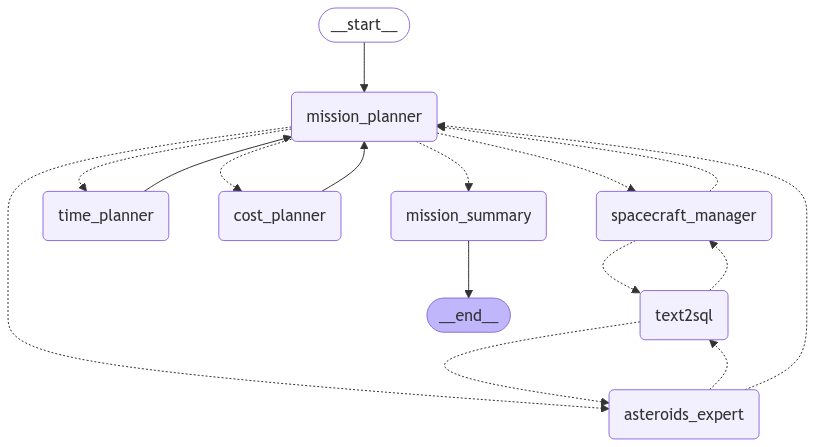

In [48]:
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

# Graph
builder = StateGraph(MissionState)

# Define nodes: these do the work
builder.add_node("mission_planner",planner)
builder.add_node("spacecraft_manager",spacecraft_manager)
builder.add_node("time_planner",time_planner)
builder.add_node("cost_planner",cost_planner)
builder.add_node("text2sql",text2sql)
builder.add_node("asteroids_expert",asteroids_expert)
builder.add_node("mission_summary",mission_summary)
# builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "mission_planner")
builder.add_conditional_edges("mission_planner",main_stage_condition,["spacecraft_manager","time_planner","cost_planner","mission_summary","asteroids_expert"])
# builder.add_conditional_edges("asteroids_expert",tools_condition,["tools"])
# builder.add_edge("asteroids_expert","mission_planner")
# builder.add_edge("tools","asteroids_expert")
builder.add_conditional_edges("asteroids_expert",text2sql_condition,["text2sql","mission_planner"])
builder.add_conditional_edges("spacecraft_manager",text2sql_condition,["text2sql","mission_planner"])
builder.add_conditional_edges("text2sql",text2sql_condition_return,["asteroids_expert","spacecraft_manager"])
# builder.add_edge("spacecraft_manager","text2sql")
# builder.add_edge("cost_planner","text2sql")
# builder.add_edge("text2sql","mission_planner")
# builder.add_edge("text2sql","spacecraft_manager")
# builder.add_edge("text2sql","cost_planner")
# builder.add_edge("spacecraft_manager","mission_planner")
builder.add_edge("time_planner","mission_planner")
builder.add_edge("cost_planner","mission_planner")
# builder.add_edge("spacecraft_manager","mission_planner")
builder.add_edge("mission_summary",END)
# builder.add_conditional_edges("spacecraft_manager", spacecraft_condition, ["mission_planner","text2sql"])


# builder.add_conditional_edges("create_analysts", END)
# react_graph = builder.compile()
memory = MemorySaver()
react_graph = builder.compile(checkpointer=memory)

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [54]:
config = {"configurable": {"thread_id": "4"}}

for event in react_graph.stream({"messages":["Plan an asteroid mining expedition with spacecraft S04."],"next_action":"","timeline_analysis":"","budget_analysis":""},config,stream_mode="values"):
    print(event)
    print("----")
    x = event

{'next_action': '', 'asteroids': [], 'spacecraft': [], 'time': [], 'cost': [], 'budget_analysis': '', 'timeline_analysis': '', 'messages': ['Plan an asteroid mining expedition with spacecraft S04.']}
----
asteroids_action
{'next_action': 'asteroids_action', 'asteroids': [], 'spacecraft': [], 'time': [], 'cost': [], 'budget_analysis': '', 'timeline_analysis': '', 'messages': ['Plan an asteroid mining expedition with spacecraft S04.', 'Gathering information about potential asteroids for mining.']}
----
text2sql
{'next_action': 'text2sql', 'asteroids': [], 'spacecraft': [], 'time': [], 'cost': [], 'budget_analysis': '', 'timeline_analysis': '', 'messages': ['Plan an asteroid mining expedition with spacecraft S04.', 'Gathering information about potential asteroids for mining.', 'Retrieve information about asteroids that are potential candidates for mining, focusing on their composition, size, and proximity to Earth.'], 'table': 'asteroids'}
----
['- Name: Anza\n- Orbit Condition Code (OCC)

In [ ]:
x

{'next_action': 'summary_action',
 'asteroids': ['- Name: Ganymed\n- Orbit Condition Code (OCC): 0\n- Diameter: 37.67 km\n- Time of Flight (TOF): 160.0 days\n- Launch Date: 2037-05-18\n- Minimal Delta-V (Min_dv): 31.36 km/s\n- Mission Duration: 348 days\n- Mining Stay: 8 days\n- Class: M\n\n',
  '- Name: Antinous\n- Orbit Condition Code (OCC): 0\n- Diameter: 2.10 km\n- Time of Flight (TOF): 440.0 days\n- Launch Date: 2042-07-27\n- Minimal Delta-V (Min_dv): 21.53 km/s\n- Mission Duration: 408 days\n- Mining Stay: 8 days\n- Class: M\n\n',
  '- Name: Daedalus\n- Orbit Condition Code (OCC): 0\n- Diameter: 3.70 km\n- Time of Flight (TOF): 440.0 days\n- Launch Date: 2040-03-31\n- Minimal Delta-V (Min_dv): 21.87 km/s\n- Mission Duration: 362 days\n- Mining Stay: 32 days\n- Class: M\n\n',
  '- Name: Sisyphus\n- Orbit Condition Code (OCC): 0\n- Diameter: 8.48 km\n- Time of Flight (TOF): 430.0 days\n- Launch Date: 2032-05-28\n- Minimal Delta-V (Min_dv): 33.37 km/s\n- Mission Duration: 364 days\n